# **An Analysis of Donald Trump's Tweets:**
# CMSC320 Final Project

**By Yichi "Rocky" Zhang, 5/16/21**

The 45th Commander-in-chief was known for his frequent use for his presence on Twitter. The tag @realDonaldTrump served as a direct window to the President's head, becoming a point of attraction for all Americans. Furthermore, it was often the first place the president's supporters, critics, and, occasionally, staff would find out about the direction Trump aimed to steer the nation. Trump's tweets are rich and diverse to say the least. He constantly leveraged Twitter to galvanize his base, criticize his political opponents, and announce policies.

As a result, Trump's tweets are a unique collection of varying sentiments, and attempting to predict the response (likes, retweets) of a Trump tweet could give insights about what tweets go "viral." In this tutorial, we will explore the tweets of the 45th president in hopes of being able to predict how many likes and retweets a fake Trump tweet would receive.

**Table of Contents:**
1.   Libraries
2.   Data Collection and Curation

    2.1 Download

    2.2 Preliminary Data Augmentation

3.   Exploratory Data Analysis
    
    3.1 Qualitative Analysis

    3.2 Quantitative Analysis

4.   Natural Language Processing
    
    4.1 Libraries

    4.2 Data Cleaning and Preprocessing

    4.3 Sentiment Analysis

5.   Machine Learning

    5.1.1 Libraries
    
    5.1.2 Creating a Train/Test Split

    5.1.3 Approach 1: Decision Tree Regressor

    5.2 Using Deep Learning

    5.2.1 Approach 2: Vectorization

    5.2.2 Approach 3: Sentiments and Vectorization

6.  Results

    6.1 Future Work
    
    6.2 Conclusion

# **1. Libraries**
Below are the standard data science libraries that we will be using. Pandas is a software library for data manipulation and analysis. It provides us with a powerful way to manipulate databases called [dataframes](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjCs6GlzM3wAhVZK80KHcqwBiUQFjAAegQIAxAD&url=https%3A%2F%2Fpandas.pydata.org%2FPandas_Cheat_Sheet.pdf&usg=AOvVaw2Z0H-ttrFe-41ta-Cnkf55). Second, we will be using [NumPy](https://numpy.org/doc/stable/reference/) in case we need to do some numerical transformations. [Seaborn](https://seaborn.pydata.org/) is a library that easily integrates with Pandas to make beautiful graphs. Internally, Seaborn uses Matplotlib's pyplot, so we include Matplotlib to manually adjust things like the title, ticks, and labels of a graph.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Our default figure size
plt.rcParams['figure.figsize'] = 6.4, 4.8

# **2. Data Collection and Curation**

# **2.1 Download**
We will download a .csv hosted on https://www.thetrumparchive.com/. Since the file is hosted on Google Drive, we will use Google's own [`gdown`](https://pypi.org/project/gdown/) command. Another option would be using a library like Tweepy, but Donald Trump's Twitter account was indefinitely suspended on January 8th, 2021, so this is not longer an option. Tweepy is an interface for Twitter's own API, so it's still subject to the restrictions of Twitter's API (in terms of limiting requests). We are also focusing on the tweets strictly during Trump's term as president. While this may leave out some gold from during the campaign, I think this time frame is appropriately focused because we can get an idea of his evolution as president.

The .csv includes the following features for each tweet:

id: The id Twitter uses internally (e.g. 20 is the id for https://twitter.com/jack/status/20). Note: At this point, ids are much longer.

text: The text content of the tweet.

isRetweet: t/f denoting whether or not the tweet was a retweet. If the tweet is a retweet, the text component will begin with `RT @______` where the @ is who is retweeted.

isDeleted: t/f denoting whether or not the tweet was deleted (before the account was suspended).

device: The device from which the tweet was sent.

favorites: The number of favorites (now called likes).

retweets: The number of retweets.

date: The date and time (UTC) of the tweet.

isFlagged: t/f denoting whether or not Twitter flagged the tweet.


In [4]:
# Download Tweet Data from 2009 to January 8th (account suspension)
! pip install gdown
! gdown https://drive.google.com/uc?id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6

Downloading...
From: https://drive.google.com/uc?id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6
To: /content/tweets_01-08-2021.csv
11.6MB [00:00, 183MB/s]


# **2.2 Preliminary Data Augmentation**
After reading the .csv into a Pandas `dataframe`, the rest are mostly housekeeping tasks. Notably, we will change the `date` column from a string to a [`datetime64`](https://numpy.org/doc/stable/reference/arrays.datetime.html) object, which is used by Numpy. This allows us to easily sort the dataframe chronologically. The timezones are also changed from UTC to EST to reflect the location of the Whitehouse. We also add columns representing the days since inauguration, the hour of the day, and the month/year of the tweet for convenience because it's often easier to see time series data is discretized chunks, such as hours/months.

In [5]:
# Use pandas to read the .csv into a Dataframe
df = pd.read_csv('tweets_01-08-2021.csv')

# Rename 'favorites' column to 'likes' (Twitter rebranded in 2015)
df.rename(columns={"favorites": "likes"}, inplace=True)

# Convert date strings to datetime64 objects
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
# Convert the UTC times to EST
# Geographic data is not taken into account
df['date'] = df.apply(lambda row: row['date'].tz_localize('UTC')\
                          .tz_convert('US/Eastern'), axis=1)

# We are only interested in data during Trump's term (2017-2021)
# Drop all other tweets
START_TERM = pd.to_datetime('2017-01-20').tz_localize('US/Eastern')
END_TERM = pd.to_datetime('2021-01-20').tz_localize('US/Eastern')
ELECTION_DAY = pd.to_datetime('2020-11-03').tz_localize('US/Eastern')
df = df[((df['date'] >= END_TERM) | (df['date'] >= START_TERM))]

# create a new series (column) for the hour of the tweet (EST)
df['hour'] = df.apply(lambda row: int(row['date'].strftime('%H')), axis=1)

# create a new series (column) for the days since Trump's inauguration
df['days_in_office'] = df.apply(lambda row: (row['date']-START_TERM).days, axis=1)

# create a new series (column) for the month and year of the tweet
df['MM-YYYY'] = df.apply(lambda row: row['date'].strftime('%m-%Y'), axis=1)

# Shows 5 tweets
df.tail(5)

,id,text,isRetweet,isDeleted,device,likes,retweets,date,isFlagged,hour,days_in_office,MM-YYYY
56566,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,t,f,Twitter for iPhone,0,20683,2020-10-22 23:46:25-04:00,f,23,1371,10-2020
56567,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9869,2020-10-22 23:42:05-04:00,f,23,1371,10-2020
56568,1319444420861829121,RT @TeamTrump: LIVE: Presidential Debate #Deba...,t,f,Twitter for iPhone,0,8197,2020-10-22 21:03:58-04:00,f,21,1371,10-2020
56569,1319384118849949702,Just signed an order to support the workers of...,f,f,Twitter for iPhone,176289,36001,2020-10-22 17:04:21-04:00,f,17,1371,10-2020
56570,1319345719829008387,Suburban women want Safety &amp; Security. Joe...,f,f,Twitter for iPhone,95169,19545,2020-10-22 14:31:46-04:00,f,14,1371,10-2020


# **3. Exploratory Data Analysis**

# **3.1 Qualitative Analysis**
This section is dedicated to giving us some broad ideas about the President's tweeting behaviors. First, we will use [Seaborn](https://seaborn.pydata.org/) to visualize the number of times that Trump tweeted at each hour of the day. As seen in the graph, the common hours of the day for a presidential tweet are 7-10 AM, suggesting Trump enjoyed tweeting during or shortly after breakfast and Fox & Friends (6 AM). After 10 AM, the frequency of dips quickly dips until 2 PM, when it starts steadily rising until midnight, except for a small dip at 6-7 PM presumably for dinner. To the amusement of the nation, there are also a handful of [late-night tweets](https://www.theatlantic.com/politics/archive/2016/10/what-trump-tweets-while-america-sleeps/503141/s://).


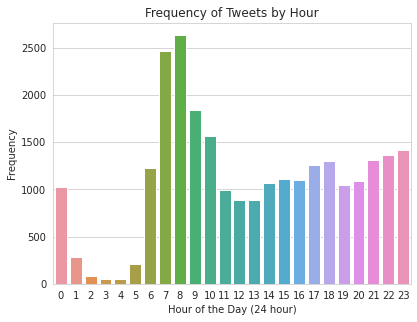

In [6]:
# Plotting frequency of tweets by hour of the day
sns.set_style("whitegrid")
ax = sns.countplot(data=df, x="hour", order=[x for x in range(24)])
ax.set(xlabel='Hour of the Day (24 hour)', ylabel='Frequency', title="Frequency of Tweets by Hour");

The scatterplot below represents each tweet as a data point, and the number of likes of the tweet is its height. Even without adding a regression line, it is clear that more of Trump's "greatest hits" on Twitter came towards the end of his presidency in terms of likes. In fact, half of the likes with more than 750 thousand likes happened after Election Day.

Number of Tweets > 750k Likes: 14
Number of Tweets > 750k Likes After Election Day: 7


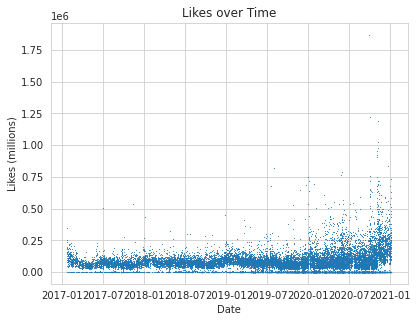

In [7]:
# Plotting likes vs. date tweeted of each tweet 
fig = sns.scatterplot(data=df, x="date", y='likes', edgecolor=None, s=1)
fig.set(xlabel='Date', ylabel='Likes (millions)', title="Likes over Time");

likes_750k = df[df['likes'] > 750000]
print(f'Number of Tweets > 750k Likes: {len(likes_750k)}')
print(f'Number of Tweets > 750k Likes After Election Day: '+ \
      str(len(likes_750k[likes_750k['date'] >= ELECTION_DAY])))

The previous scatter plot was a bit messy. Instead of plotting on a continuous domain, let's plot the relevant features by month. Below we plot each month's total tweets, average likes, and average retweets. We immediately see that there is a strong correlation between likes and retweets since they appear to track each other nearly perfectly when averaged over the month. The two also appear to rise and fall more or less seasonally until November 2020 (election month. The number of tweets appears to steadily increase every until the election as well. After losing the election, the number of tweets tapers off dramatically, while likes and retweets rising dramatically. Combined with the fact that half of Trump's tweets with over 750 thousand likes occurred after election day, we can infer that the increase in likes after the election is from Trump's critics.

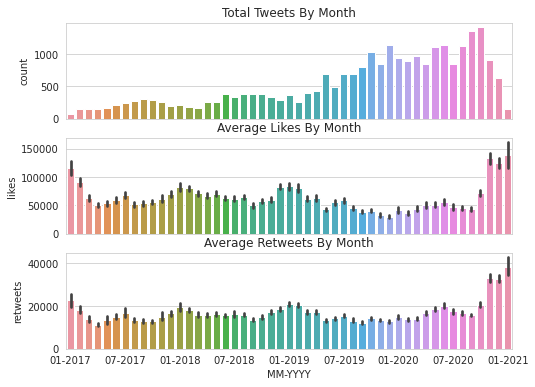

In [8]:
# Increase the size of this plot
plt.rcParams['figure.figsize'] = (8, 6)

# Sort the values chronologically, so the labels appear in order
df.sort_values(['date'], inplace=True)

# Plot the number of tweets, average likes, average retweets on each month
# in a single plot (3 subplots)
fig, ax = plt.subplots(3,1, sharex=True)
sns.countplot(ax=ax[0], data=df, x='MM-YYYY')
sns.barplot(ax=ax[1], data=df, x='MM-YYYY', y='likes')
rt_plt = sns.barplot(ax=ax[2], data=df, x='MM-YYYY', y='retweets')

# Only show a label for one in six months to avoid cramped labels
for i, label in enumerate(rt_plt.xaxis.get_ticklabels()):
    if i % 6 != 0: label.set_visible(False);

# Formatting and adding titles
ax[0].xaxis.label.set_visible(False)
ax[1].xaxis.label.set_visible(False)
ax[0].set(title="Total Tweets By Month")
ax[1].set(title="Average Likes By Month")
ax[2].set(title="Average Retweets By Month")

# Reset plot sizes
plt.rcParams['figure.figsize'] = (6.4, 4.8);

# **3.2 Quantitative Analysis**
Recall our end goal is to be able to predict the amount of likes and retweets a tweet will get. Visualizing the correlations between the quantitative features we have so far could help, so I constructed a heat map of the correlations between each of the variables. As we noted earlier, likes and retweets seem to have a strong correlation (r=0.77), but none of our other variables seem to correlate well with either likes or retweets. This is unsurprising because it would be almost magical if we were able to predict likes soley off the time.

Of course, in order to predict how well a tweet will do we must have some idea of its (text) contents. Enter: natural language processing.

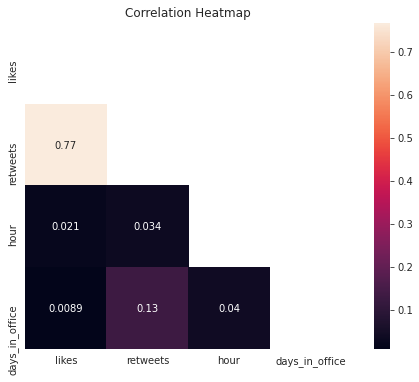

In [9]:
plt.rcParams['figure.figsize'] = (8, 6)

# id is a number and thus quantitative but we know it will be useless
# Compute the correlation matrix
corr = df[['likes', 'retweets', 'hour', 'days_in_office']].corr()

# Mask off the upper triagle because it's redundant
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heat map
fig = sns.heatmap(data=corr, square=True, annot=True, mask=mask)
fig.set(title='Correlation Heatmap')

# Reset plot sizes
plt.rcParams['figure.figsize'] = (6.4, 4.8);

# **4. Natural Language Processing**
The goal of applying NLP is to get us features related to the substantive contents of the tweet in hopes that they will allow us to predict the reception of the tweet (better than trivial proporties like time of day).

# **4.1 Libraries**
re, emoji, and string are used to "clean" the data. In particular, we want to make the data more consistent in order to do sentiment analysis on it. The two other libraries more or less revolve around [re](https://www.debuggex.com/cheatsheet/regex/python://), which uses regular expressions to make widespread substitutions and deletions.

nltk and textblob will be used to do sentiment analysis. We will be avoid the specfic techniques that each use but more information can be found here for [nltk](https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer) ([vader](https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664)) and [textblob](https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment). Here's another tutorial for using [vader](https://www.youtube.com/watch?v=Alu_cCXNS-k).

In [10]:
import re
import string
!pip install emoji
import emoji

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

!pip install textblob
from textblob import TextBlob

     |████████████████████████████████| 133kB 7.0MB/s 


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# **4.2 Data Cleaning and Preprocessing**
The goal is to extract the sentiment from each tweet, and several features of tweets make this trick. Look at the tweet below: it contains things such as links, the retweet prefix, and puncuation that are not part of natural language. So we will remove the aforementioned nuisances to make the text more easily digestible. We will also make the text all lowercase for the same reason. 

In [11]:
# Sample problematic tweet 1
print(df['text'][214])

# Instance of weird &amp; encoding issue (problematic tweet 2)
print(df['text'][56570])

RT @DanScavino: 🔊WOW! We hear you from the West Wing—THANK YOU❤️🇺🇸🦅 https://t.co/onytmaJUhp
Suburban women want Safety &amp; Security. Joe Biden cannot give that to anyone! https://t.co/NWSZ5tGz5E


Looking at the cleaned version of the problematic string, we see that it is now much more digestable now that the emojis, puncuation, and retweet prefix are removed.

In [12]:
def strip_emoji(text):
    new_text = re.sub(emoji.get_emoji_regexp(), r'', text)
    return new_text

remove_rt = lambda x: re.sub(r'RT @\w+: ', ' ', x)
remove_links = lambda x: re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)

for index, row in df.iterrows():
    txt = row['text']

    txt = re.sub(r'&amp;', ' ', txt) # removes annoying '&amp;' encoding thing

    # removes the prefix to retweets if needed
    if row['isRetweet'] == 't': txt = remove_rt(txt)
    
    txt = remove_links(txt) # deletes links
    txt = strip_emoji(txt) # removes all emojis :((
    txt = txt.lower() # makes all text lowercase
    txt = txt.translate(str.maketrans('', '', string.punctuation+'—')) # removes punctuation

    df.loc[index, 'clean_txt'] = txt

# Problematic tweet 1 after cleaning
print(df['clean_txt'][214])

 wow we hear you from the west wingthank you️  


# **4.3 Sentiment Analysis**
Using TextBlob, we get the polarity and subjectivity of each tweet. Using NLTK, we can get the compound, negative, neutral, and negative scores for each tweet.

In [13]:
# Iterating over each row
for index, row in df.iterrows():
    txt = row['clean_txt']

    # Determining polarity and subjectivity scores
    txtblb_res = TextBlob(txt).sentiment
    df.loc[index, 'pol'], df.loc[index, 'subj'] = \
            txtblb_res.polarity, txtblb_res.subjectivity

    # Determining compound, negative, neutral, and negative score
    vadar_res = SentimentIntensityAnalyzer().polarity_scores(txt)
    df.loc[index, 'comp'] = vadar_res['compound']
    df.loc[index, 'neg'] = vadar_res['neg']
    df.loc[index, 'neu'] = vadar_res['neu']
    df.loc[index, 'pos'] = vadar_res['pos']

df.head(5)

,id,text,isRetweet,isDeleted,device,likes,retweets,date,isFlagged,hour,days_in_office,MM-YYYY,clean_txt,pol,subj,comp,neg,neu,pos
45739,822421390125043713,It all begins today! I will see you at 11:00 A...,f,f,Twitter for Android,232628,57772,2017-01-20 07:31:53-05:00,f,7,0,01-2017,it all begins today i will see you at 1100 am ...,0.00,0.0,0.0000,0.000,1.000,0.000
45738,822501803615014918,Today we are not merely transferring power fro...,f,f,Twitter for iPhone,94860,16452,2017-01-20 12:51:25-05:00,f,12,0,01-2017,today we are not merely transferring power fro...,0.25,0.5,0.2144,0.000,0.919,0.081
45737,822501939267141634,"power from Washington, D.C. and giving it back...",f,f,Twitter for iPhone,78281,14880,2017-01-20 12:51:58-05:00,f,12,0,01-2017,power from washington dc and giving it back to...,0.00,0.0,0.3400,0.000,0.844,0.156
45736,822502135233384448,What truly matters is not which party controls...,f,f,Twitter for iPhone,157266,35758,2017-01-20 12:52:45-05:00,f,12,0,01-2017,what truly matters is not which party controls...,0.00,0.0,0.0954,0.079,0.776,0.145
45735,822502270503972872,"January 20th 2017, will be remembered as the d...",f,f,Twitter for iPhone,197191,54888,2017-01-20 12:53:17-05:00,f,12,0,01-2017,january 20th 2017 will be remembered as the da...,0.00,0.0,0.0000,0.000,1.000,0.000


The code block below shows the impact of preprocessing on the first problematic tweet from the section above. Without preprocessing, we would be completely unable to extract any sentiment from that particular tweet.

In [ ]:
print(f'No preprocesing: ' + str(TextBlob(df['text'][214]).sentiment))
print(f'With preprocesing: ' + str(TextBlob(df['clean_txt'][214]).sentiment))

No preprocesing: Sentiment(polarity=0.0, subjectivity=0.0)
With preprocesing: Sentiment(polarity=0.1, subjectivity=1.0)


After doing sentiment analysis over the whole dataset, we want to see if there are new promising features that may help us create a regressor. Once again, we will create a correlation heat map to see if any of the new features has a strong correlation with likes or retweets.

After generating the heat map below, this sadly does not seem to be the case. None of the correlation coefficients relating to likes or retweets seem to be greater than 0.15, meaning there is very little correlation.

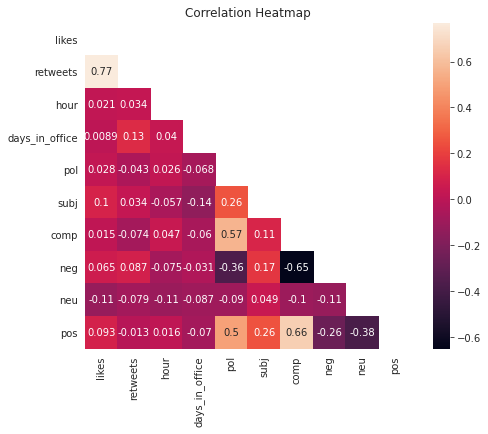

In [14]:
# Resize plot
plt.rcParams['figure.figsize'] = (8, 6);

# id is a number and thus quantitative but we know it will be useless
# Compute the correlation matrix
corr = df.drop(columns='id').corr()

# Mask off the upper triagle because it's redundant
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heat map
fig = sns.heatmap(data=corr, square=True, annot=True, mask=mask);
fig.set(title='Correlation Heatmap')

# Reset plot sizes
plt.rcParams['figure.figsize'] = (6.4, 4.8);

# **5. Machine Learning**
Remaining undeterred, we may still be able to create a model using these features. Since our six sentiment features seem rather straightforward, we may be able to construct a simple decision tree regressor to predict the likes/retweets of a tweet. For an accessible, nontechnical introduction to decision trees, check out this [article](https://hbr.org/1964/07/decision-trees-for-decision-making). TLDR: the model is playing 20 questions to predict/classify data.

I suspect a decision tree model because Trump's base would love his bluntly negative tweets that he addressed to his critics, so it's possible that heavily negative and subjective tweets are prone to get many likes and retweets.

# **5.1.1 Libraries**
Everything we need is in sklearn. Each thing will be discussed in passing.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# **5.1.2 Creating a Train/Test Split**
As with any machine learning technique, we have to differentiate between data that we train on and data that we test on. Testing and training on the same data would be like a professor giving you a study guide and telling you it's a copy of the exam. Then, you would not learn to apply anything and simply memorize the answers. We'll use a train/test split of 8:2, determined by sklearn's `train_test_split` function.

In [16]:
# Our training features (independent variables)
x = df[['pol', 'subj', 'comp', 'neg', 'neu', 'pos']]
# What we are trying to predict
y = df[['likes', 'retweets']]

# 80% of the data will be assigned to the training data, and the rest to testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train.shape, x_test.shape

((20989, 6), (5248, 6))

# **5.1.3 Approach 1: Decision Tree Regressor**
A decision tree is a group of paths of nodes originating from a single point (root). At each node, a decision is made that determines what node you travel to next. Decision trees' "decisions" are splits on variables that divide whatever inputs are fed to it (e.g. bringing an umbrella if chance of rain is greater than 30%). When used for classification, a decision tree splits the input data continuously in order to predict categories that a sample falls under. Regression tasks are similar, but the tree predicts some value(s) for the target feature.

Unfortunately, the results of using a decision tree regressor were horrible. We achieved a test $R^2$ value of 0.026, meaning the model was able to explaing 2.6% of the variance in the predictions, which is basically the same as predicting with a horizontal line. A depth of 7 was used, and I was unable to use a larger depth without overfitting.

In [17]:
# Supress annoying warning
import warnings
warnings.filterwarnings("ignore")

dec_tree = DecisionTreeRegressor(max_depth=7)
# Fit the model 
dec_tree.fit(x_train, y_train)

# Predict the target value from the model for the samples
test_pred = dec_tree.predict(x_test)
train_pred = dec_tree.predict(x_train)

# Computing the accuracy of the model performance
train_r2 = dec_tree.score(x_train, y_train)
test_r2 = dec_tree.score(x_test, y_test)

# Compute root mean squared error (RMSE)
rmse_train_tree = np.sqrt(mean_squared_error(y_train, train_pred))
rmse_test_tree = np.sqrt(mean_squared_error(y_test, test_pred))

print('Training Data: --------------------------------------')
print('Coefficient of Determination (R^2): {:.3f}'.format(train_r2))
print('RMSE:', rmse_train_tree)

print('Test Data: ------------------------------------------')
print('Coefficient of Determination (R^2): {:.3f}'.format(test_r2))
print('RMSE:', rmse_test_tree)
print('-----------------------------------------------------\n')

Training Data: --------------------------------------
Coefficient of Determination (R^2): 0.161
RMSE: 49223.71667398689
Test Data: ------------------------------------------
Coefficient of Determination (R^2): 0.077
RMSE: 49891.88405576381
-----------------------------------------------------



# **5.2 Using Deep Learning**
In hindsight, it does not appear that sentiment features were enough to make a good model. A potential explaination is that the Trump's more well received tweets may have been well-received by either his base or his opposition, so the model have have been "confused" by these two causes especially since they are not directly reflected in the sentiments directly.

Another solution could be employing a neural network. By using deep learning on the text directly, we may be able to get better results if the network is able to learn the data with more granularity. Instead of looking at summary statistics like sentiments as the decision tree did, the neural network will be learning on a representation of the words themselves (a vector).

# **5.2.1 Approach 2: Vectorization**

`CountVectorizer` provides a sparse feature representation by default to save memory which is reasonable because only some words occur in individual example. However, for training neural network models, we generally use a dense representation vector. `MLPRegressor` will then be used to calculate the loss and backpropagate on us to train the model. 

Iteration 1, loss = 2317804757.81797886
Iteration 2, loss = 1661878228.03720188
Iteration 3, loss = 1350895993.98036098
Iteration 4, loss = 1275588132.97436190
Iteration 5, loss = 1215323787.91857600
Iteration 6, loss = 1163848458.67648625
Iteration 7, loss = 1122073666.03160501
Iteration 8, loss = 1087968042.00100160
Iteration 9, loss = 1059488154.03140748
Iteration 10, loss = 1036801237.19555664

MLP MODEL USING VECTORIZATION ONLY:
Training Data: --------------------------------------
Coefficient of Determination (R^2): 0.297
RMSE: 49223.71667398689
Test Data: ------------------------------------------
Coefficient of Determination (R^2): 0.214
RMSE: 49891.88405576381
-----------------------------------------------------



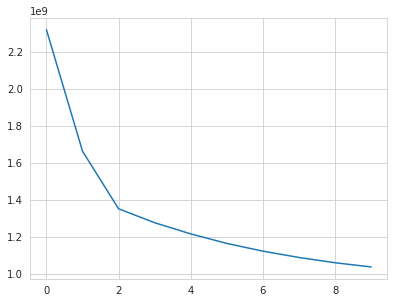

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

# Generating Train/Test Split
x = df['clean_txt']
y = df[['likes', 'retweets']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Fit data using CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=4000, ngram_range=(1, 2))
x_train, x_test = cv.fit_transform(x_train), cv.transform(x_test)

x_train = np.array(x_train.todense()).astype(float)
x_test = np.array(x_test.todense()).astype(float)
y_train, y_test = np.array(y_train), np.array(y_test)

# Initialize multi-layer perceptron regressor 
clf = MLPRegressor(hidden_layer_sizes=(100,200,100), learning_rate='adaptive', 
                  solver='adam', learning_rate_init=0.001, max_iter=10,
                   verbose=True, random_state=0)
clf.fit(x_train, y_train)

print('\nMLP MODEL USING VECTORIZATION ONLY:')
print('Training Data: --------------------------------------')
print(f'Coefficient of Determination (R^2): {clf.score(x_train, y_train):.3f}')
print('RMSE:', rmse_train_tree)

print('Test Data: ------------------------------------------')
print(f'Coefficient of Determination (R^2): {clf.score(x_test, y_test):.3f}')
print('RMSE:', rmse_test_tree)
print('-----------------------------------------------------\n')

sns.lineplot(x=[a for a in range(len(clf.loss_curve_))], y=clf.loss_curve_)
fig.set(title='Loss Curve');

# **5.2.2 Approach 3: Sentiments and Vectorization**

Perhaps we would be able to get better results if we combined the sentiments from Section 5.1 with the vectorization techniques from the previous section. We just append the sentiment vectors onto the back of the `CountVectorizer`.

Iteration 1, loss = 2312252913.80813169
Iteration 2, loss = 1627045596.42819786
Iteration 3, loss = 1333930615.17270350
Iteration 4, loss = 1268524194.98805666
Iteration 5, loss = 1214144539.24404955
Iteration 6, loss = 1167470997.76881480
Iteration 7, loss = 1127501408.65916586
Iteration 8, loss = 1093946938.76358581
Iteration 9, loss = 1065723739.33932734
Iteration 10, loss = 1041872310.45328760
Iteration 11, loss = 1020060712.82641613
Iteration 12, loss = 999980665.72163653
MLP MODEL USING VECTORIZATION AND SENTIMENTS:
Training Data: --------------------------------------
Coefficient of Determination (R^2): 0.322
RMSE: 49223.71667398689
Test Data: ------------------------------------------
Coefficient of Determination (R^2): 0.218
RMSE: 49891.88405576381
-----------------------------------------------------



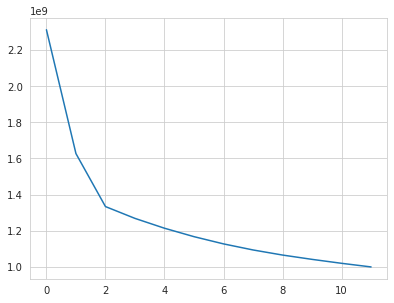

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

# Generating Train/Test Split
x = df[['clean_txt','pol', 'subj', 'comp', 'neg', 'neu', 'pos']]
y = df[['likes', 'retweets']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Get sentiments
x_train_sents = x_train[['pol', 'subj', 'comp', 'neg', 'neu', 'pos']].to_numpy()
x_test_sents = x_test[['pol', 'subj', 'comp', 'neg', 'neu', 'pos']].to_numpy()

# Fit data using CountVectorizer
x_train, x_test = x_train['clean_txt'], x_test['clean_txt']
cv = CountVectorizer(stop_words="english", max_features=4000, ngram_range=(1, 2))
x_train, x_test = cv.fit_transform(x_train), cv.transform(x_test)

x_train = np.array(x_train.todense()).astype(float)
x_test = np.array(x_test.todense()).astype(float)

# Concatenate sentiments onto training and testing vectors
x_train = np.concatenate((x_train, x_train_sents), axis=1)
x_test = np.concatenate((x_test, x_test_sents), axis=1)

y_train, y_test = np.array(y_train), np.array(y_test)

# Initialize multi-layer perceptron regressor 
clf = MLPRegressor(hidden_layer_sizes=(100,200,100), learning_rate='adaptive', 
                  solver='adam', learning_rate_init=0.001, max_iter=12,
                   verbose=True, random_state=0)
clf.fit(x_train, y_train)

print('\nMLP MODEL USING VECTORIZATION AND SENTIMENTS:')
print('Training Data: --------------------------------------')
print(f'Coefficient of Determination (R^2): {clf.score(x_train, y_train):.3f}')
print('RMSE:', rmse_train_tree)

print('Test Data: ------------------------------------------')
print(f'Coefficient of Determination (R^2): {clf.score(x_test, y_test):.3f}')
print('RMSE:', rmse_test_tree)
print('-----------------------------------------------------\n')

sns.lineplot(x=[a for a in range(len(clf.loss_curve_))], y=clf.loss_curve_)
fig.set(title='Loss Curve');

# **6. Results**

Our initial goal was to predict the reception of Trump's tweets based off their content in order to potentially gain. Our first approach involved making a decision tree regressor based off features from analysis analysis. The coefficient of determination on the training and testing sets were $R^2 = 0.161$ and $R^2 = 0.077$. Based off the test $R^2$, the model is trash because it's only 7% better than using a straight line as a predictor. Next, we decided to vectorize the tweets and used a deep learning (multi-layer perceptron) model in hopes that directly representing the text as a vector would be a better representation of the tweets. The intution behind this is that sentiments are a summary of the tweet that lose some of the minutia of the tweet, whereas vectorization captures more of the tweets details by representing the contents of the tweet. For the test set, this resulted in $R^2 = 0.214$, which is considerably better than the decision tree. I suspect this is because a vector is a more detailed representation of a tweet. Continuing this line of thought, I thought it would make sense to use both the vectorization and the sentiment features in tandem in a deep learning model, so the third attempt did just that. Hopefully, the general sentiment features complimented the `CountVectorizer` features to make a more accurate regression. This third attempt resulted $R^2 = 0.218$, which is negligibly better than the vector only model.

# **6.1 Future Work**

A possible improvement we could have made would have been utilizing TF-IDF instead of a vectorized model. A paper by Daga et al. suggests, "The overall low accuracy of all our models can be because the Doc2Vec \[vector\] technique is built for large texts i.e. 50+ words," meaning vectorization on short text like tweets is rather ineffective because the model is not given enough context. As for deep learning approaches, the authors note, "Even though Deep Learning is a highly sought after approach when dealing with unstructured data (such as textual data) or when trying to increase the accuracy, we can say that it is not always the best." In fact, it should be noted that the best model found by the researchers in terms of testing accuracy was a random forest vectorized model, which could be tested in the future. 

# **6.2 Conclusion**

Hopefully, you learned a lot from this tutorial. I had a lot putting it together, and I hope you enjoyed pouring over the 45th president's tweets as much as I did.

\- Yichi "Rocky" Zhang